In [181]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import myPreprocessors as mypp #nuestra librerías de transformaciones.

import joblib

In [182]:
df = pd.read_csv("LoanDefault2.csv",sep=";")
df.head()

ID  year loan_limit             Gender approv_in_adv loan_type  \
0  25159  2019         cf  Sex Not Available         nopre     type1   
1  25249  2019         cf  Sex Not Available         nopre     type1   
2  25394  2019         cf  Sex Not Available         nopre     type1   
3  26024  2019         cf  Sex Not Available         nopre     type1   
4  27400  2019         cf  Sex Not Available         nopre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p3                l1        nopc                  nob/c  ...   
1           p3                l1        nopc                  nob/c  ...   
2           p3                l1        nopc                  nob/c  ...   
3           p3                l1        nopc                  nob/c  ...   
4           p3                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0         EQUI           700                       EXP  35-44   
1         EQUI           597                       EXP  65-74   
2         EQUI           730                       EXP    >74   
3         EQUI           657                       EXP  55-64   
4         EQUI           507                       EXP  65-74   

   submission_of_application LTV Region Security_Type  Status dtir1  
0                    to_inst NaN  south        direct       1   NaN  
1                    to_inst NaN  south        direct       1   NaN  
2                    to_inst NaN  south        direct       1   NaN  
3                    to_inst NaN  south        direct       1   NaN  
4                    to_inst NaN  south        direct       1   NaN  

[5 rows x 34 columns]

In [183]:
df.dtypes

ID                             int64
year                           int64
loan_limit                    object
Gender                        object
approv_in_adv                 object
loan_type                     object
loan_purpose                  object
Credit_Worthiness             object
open_credit                   object
business_or_commercial        object
loan_amount                    int64
rate_of_interest             float64
Interest_rate_spread         float64
Upfront_charges              float64
term                         float64
Neg_ammortization             object
interest_only                 object
lump_sum_payment              object
property_value               float64
construction_type             object
occupancy_type                object
Secured_by                    object
total_units                   object
income                       float64
credit_type                   object
Credit_Score                   int64
co-applicant_credit_type      object
a

#### 2. Train Test Split para Entrenamiento y Prueba

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['ID', 'Status'], axis=1),
    df['Status'],
    test_size=0.3,
    random_state=2023)


#### 3. Configuración del Pipeline

In [185]:
#imputación de variables categóricas
CATEGORICAL_VARS_WITH_NA_FREQUENT = []

#imputación de variables categoricas con indicador de Faltante (Missing)
CATEGORICAL_VARS_WITH_NA_MISSING = ['loan_limit', 'approv_in_adv','loan_purpose', 'Neg_ammortization']

#Imputación de variables numéricas
NUMERICAL_VARS_WITH_NA = []

#Outliers
NUMERICAL_VARS_WITH_OUTLIERS = ['loan_amount']


#Variables temporales
TEMPORAL_VARS = []

#Año de Referencia
REF_VAR = ""

#Variables para Binarización por sesgo
BINARIZE_VARS = []

#Variables que eliminaremos
DROP_FEATURES = ["YrSold"]

#Variables para transfomraicón logarítmica
NUMERICAL_LOG_VARS = []

#Variables para codificación ordinal.
QUAL_VARS = []

#variables especiales


#Variables que eliminaremos
DROP_FEATURES = ["year"]

#Variables para codificación por frecuencia (no ordinal)
CATEGORICAL_VARS = ['loan_limit','Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
'Credit_Worthiness',
'open_credit',
'business_or_commercial',
'Neg_ammortization',
'interest_only',
'lump_sum_payment',
'construction_type',
'occupancy_type',
'Secured_by',
'total_units',
'credit_type',
'co-applicant_credit_type',
'age',
'submission_of_application',
'Region',
'Security_Type']

#Mapeo para varibels categótricas para calidad.
ExampleMaping = {}


#Variables a utilzar en el entrenamiento
FEATURES = [
'loan_limit',
 'Gender',
 'approv_in_adv',
 'loan_type',
 'loan_purpose',
 'Credit_Worthiness',
 'open_credit',
 'business_or_commercial',
 'loan_amount',
 'Neg_ammortization',
 'interest_only',
 'lump_sum_payment',
 'construction_type',
 'occupancy_type',
 'Secured_by',
 'total_units',
 'credit_type',
 'co-applicant_credit_type',
 'age',
 'submission_of_application',
 'Region',
 'Security_Type'
]

In [186]:
X_train = X_train[FEATURES]

In [187]:
from sklearn.ensemble import GradientBoostingClassifier

#### 4. Construcción del Pipeline

In [188]:
modelo_gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=200)

In [189]:
LoanDefaultv012023 = Pipeline([
    
    #=========== IMPUTACIONES ===============
    
    #1. Imputaciín de variables categóricas con indicador de faltante
    ('missing_imputation',
        CategoricalImputer(imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)
    ),
    #============= CODIFICACIÓN DE VARIABLES CATEGORICAS NOMINALES ==================
    ('rare_label_encoder',
        RareLabelEncoder(n_categories=1, tol=0.01, variables=CATEGORICAL_VARS)
    ),
    
    ('categorical_encoder',
        OrdinalEncoder(encoding_method='ordered', variables=CATEGORICAL_VARS)
    ),

     #=============== SCALER ============
    ('scaler',
        MinMaxScaler()
    ),
    
    ('modelo_gradient_boosting', modelo_gb )
])

In [191]:
LoanDefaultv012023.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['loan_limit', 'approv_in_adv',
                                               'loan_purpose',
                                               'Neg_ammortization'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables=['loan_limit', 'Gender',
                                             'approv_in_adv', 'loan_type',
                                             'loan_purpose',
                                             'Credit_Worthiness', 'open_credit',
                                             'business_or_commercial',
                                             'Neg_ammortizatio...
                                           'business_or_commercial',
                                           'Neg_ammortization', 'interest_only',
                                           'lump_sum_payment',
                                           'construction_type',
                                           'occupancy_type', 'Secured_by',
                                           'total_units', 'credit_type',
                                           'co-applicant_credit_type', 'age',
                                           'submission_of_application',
                                           'Region', 'Security_Type'])),
                ('scaler', MinMaxScaler()),
                ('modelo_gradient_boosting',
                 GradientBoostingClassifier(max_depth=5, n_estimators=200))])

In [192]:
X_test = X_test[FEATURES]


In [206]:
pred = LoanDefaultv012023.predict(X_test)

In [209]:
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

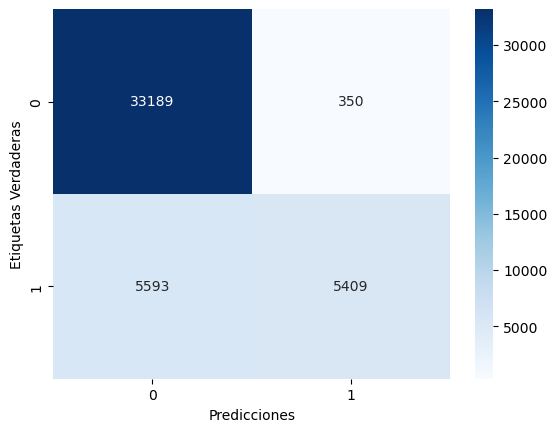

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()



In [197]:
#guardamos pipeline para uso en producción.
joblib.dump(LoanDefaultv012023, 'LoanDefaultv012023.pkl')

['LoanDefaultv012023.pkl']

In [198]:
joblib.dump(FEATURES, 'FEATURES.pkl')

['FEATURES.pkl']